In [7]:
import tensorflow as tf
from tensorflow .keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [8]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=70

In [9]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/lung-cancer-min/Lung Cancer",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2700 files belonging to 3 classes.


In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
class_names=dataset.class_names

In [12]:
class_names

['Benign', 'Malignant', 'Normal']

In [13]:
len(dataset)

85

In [14]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 0 1 2 0 2 0 2 2 0 0 1 2 0 1 0 0 1 0 1 1 2 2 0 1 1 1 2 0 2 1]


In [15]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 ...

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]]


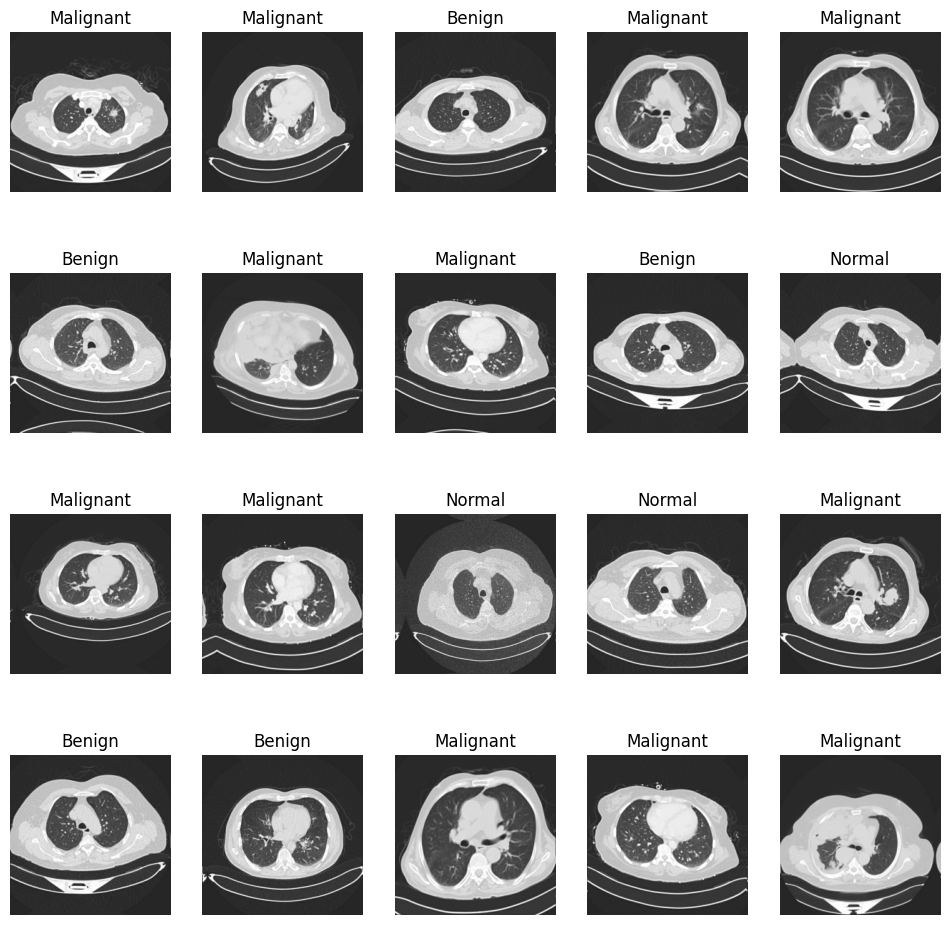

In [16]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(20):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

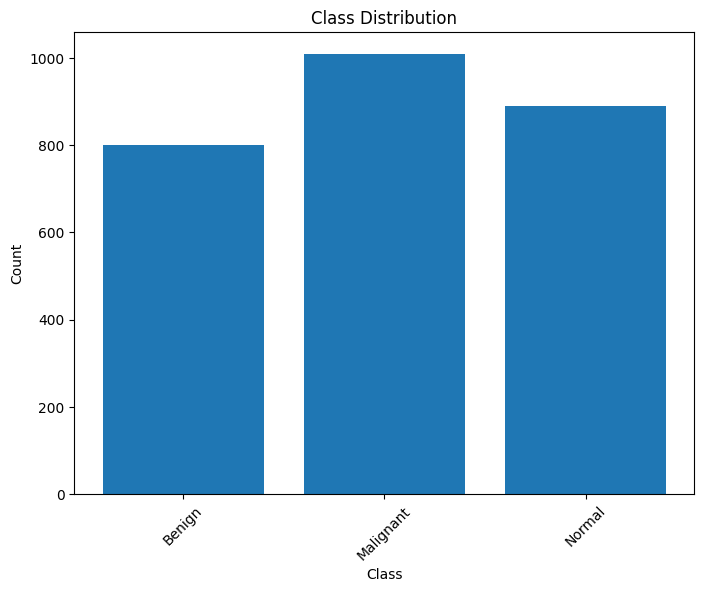

In [17]:
#It willl perform class distribution
plt.figure(figsize=(8, 6))
class_counts = [0] * len(class_names)
for _, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1
plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [18]:
# Compute and visualize mean and standard deviation of pixel values
mean_pixels = []
std_pixels = []
for images, _ in dataset:
    mean_pixels.append(tf.math.reduce_mean(images, axis=[0, 1, 2]))
    std_pixels.append(tf.math.reduce_std(images, axis=[0, 1, 2]))

mean_pixels = tf.math.reduce_mean(mean_pixels, axis=0)
std_pixels = tf.math.reduce_mean(std_pixels, axis=0)
print("Mean pixel values:", mean_pixels.numpy())
print("Standard deviation of pixel values:", std_pixels.numpy())


Mean pixel values: [100.635475 100.635475 100.635475]
Standard deviation of pixel values: [75.40967 75.40967 75.40967]


In [ ]:
# Plot histogram of pixel intensities for each channel
plt.figure(figsize=(15, 5))
for i in range(CHANNELS):
    plt.subplot(1, CHANNELS, i + 1)
    plt.hist(images[:, :, :, i].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Channel {i+1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [20]:
#Split dataset into train_ds,val_ds,test_ds.
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=121)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [21]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [22]:
len(train_ds)

68

In [23]:
len(val_ds)

8

In [24]:
len(test_ds)

9

In [25]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [27]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [28]:
resize_and_rescale

<Sequential name=sequential, built=False>

In [29]:
data_augmentation

<Sequential name=sequential_1, built=False>

In [30]:
IMAGE_SIZE

256

In [31]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

# **CNN MODEL**

In [32]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
history=model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=EPOCHS)

Epoch 1/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.3722 - loss: 1.0999 - val_accuracy: 0.3984 - val_loss: 1.0931
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3557 - loss: 1.0953 - val_accuracy: 0.5117 - val_loss: 1.0036
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5009 - loss: 1.0107 - val_accuracy: 0.5664 - val_loss: 0.8951
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5442 - loss: 0.9183 - val_accuracy: 0.5898 - val_loss: 0.8476
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5886 - loss: 0.8676 - val_accuracy: 0.6406 - val_loss: 0.7612
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5858 - loss: 0.8468 - val_accuracy: 0.6445 - val_loss: 0.7636
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6213 - loss: 0.7698 - val_accuracy: 0.7188 - val_loss: 0.7099
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6657 - loss: 0.7298 - val_accuracy: 0.5195 -

In [36]:
scores=model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9401 - loss: 0.1395


In [37]:
scores

[0.14055094122886658, 0.9409722089767456]

In [38]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 68}

In [39]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


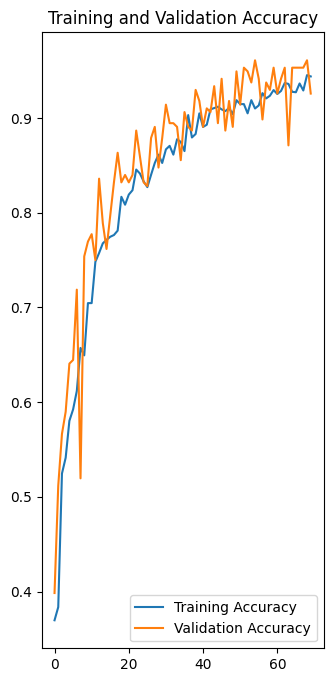

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

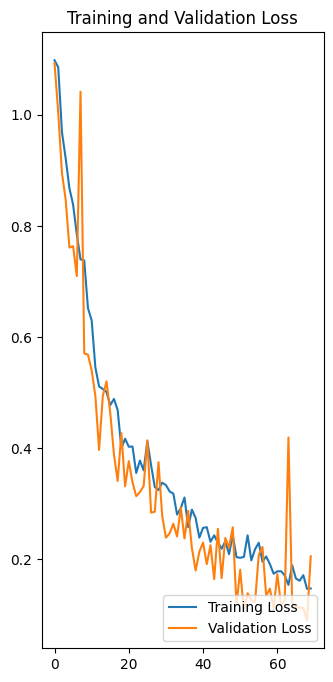

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title("Training and Validation Loss")
plt.show()

Image to predict
Actual Label: Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Label: Benign


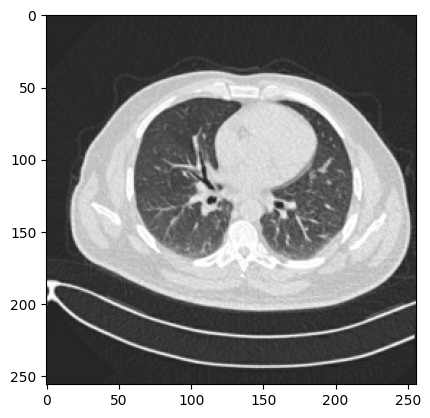

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


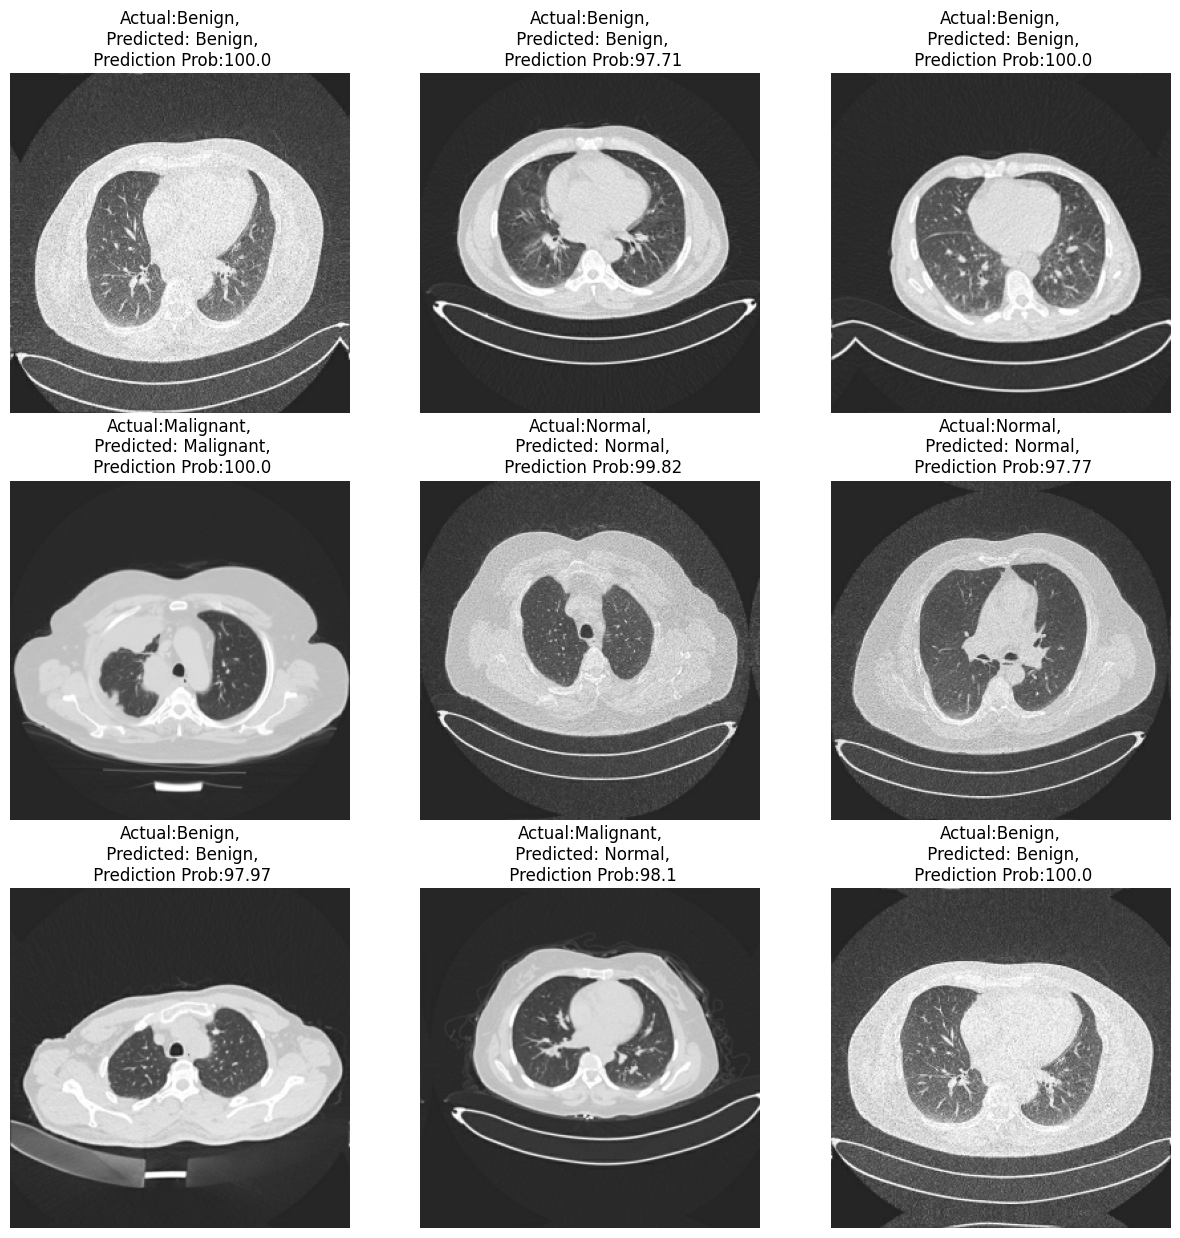

In [44]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())

        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Prediction Prob:{confidence}")
        plt.axis("off")

# **VGGNET (WITHOUT FINETUNING) **

In [45]:
#VggNet
from tensorflow.keras.applications import VGG16


In [46]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [47]:
base_model.trainable = False


In [48]:
model_vg= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model_vg.build(input_shape=input_shape)


In [49]:
# Compile the model
model_vg.compile(optimizer='Adam',  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [50]:
model_vg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (32, 8, 8, 512)        │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 32768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 256)              │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,144,899 (88.29 MB)

 Trainable params: 8,430,211 (32.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
history=model_vg.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=EPOCHS)

Epoch 1/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.4598 - loss: 1.9760 - val_accuracy: 0.7773 - val_loss: 0.5856
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.7710 - loss: 0.5112 - val_accuracy: 0.8477 - val_loss: 0.3165
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8202 - loss: 0.4158 - val_accuracy: 0.8398 - val_loss: 0.3910
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8313 - loss: 0.3633 - val_accuracy: 0.8203 - val_loss: 0.3839
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8791 - loss: 0.2920 - val_accuracy: 0.9336 - val_loss: 0.1605
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8947 - loss: 0.2410 - val_accuracy: 0.8516 - val_loss: 0.2991
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9013 - loss: 0.2477 - val_accuracy: 0.9648 - val_loss: 0.1222
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9345 - loss: 0.1625 - val_accuracy: 0

In [52]:
scores=model_vg.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9929 - loss: 0.0284


In [53]:
scores

[0.04216506704688072, 0.9861111044883728]

In [54]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


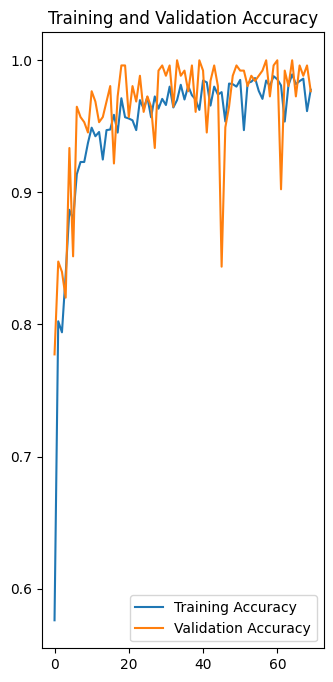

In [55]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

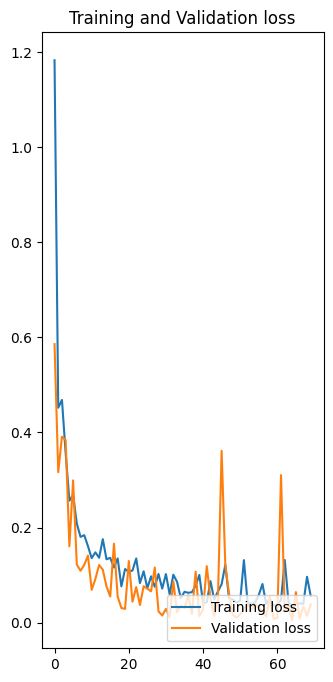

In [56]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training and Validation loss")
plt.show()

Image to predict
Actual Label: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted Label: Normal


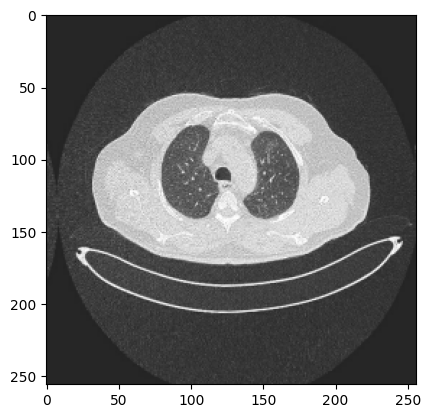

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction=model_vg.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


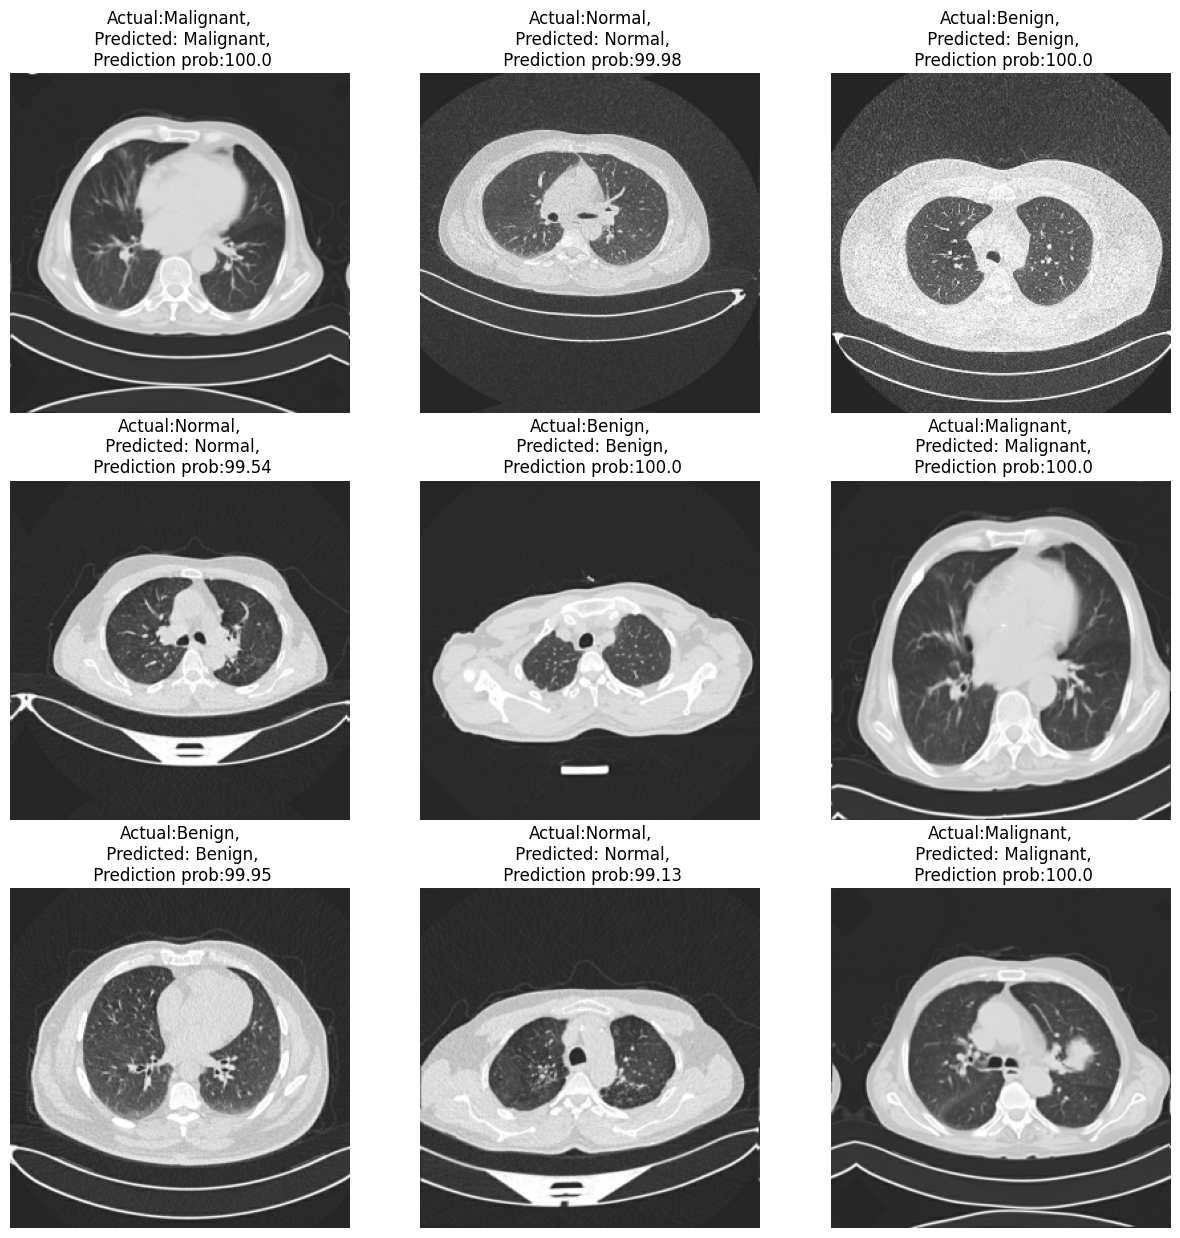

In [59]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model_vg,images[i].numpy())

        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Prediction prob:{confidence}")
        plt.axis("off")

# **VGGNET  (With FineTuning)**


In [93]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [94]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

In [95]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer_9 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [96]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [97]:
model_vgg_ft = Sequential()
model_vgg_ft.add(conv_base)
model_vgg_ft.add(Flatten())
model_vgg_ft.add(Dense(256,activation='relu'))
model_vgg_ft.add(Dense(3,activation='softmax'))

In [98]:
model_vgg_ft.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [99]:
history = model_vgg_ft.fit(train_ds,epochs=20,validation_data=val_ds)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.6963 - loss: 15.1903 - val_accuracy: 0.9688 - val_loss: 0.3255
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9693 - loss: 1.2215 - val_accuracy: 0.9688 - val_loss: 0.4351
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9877 - loss: 0.7662 - val_accuracy: 0.9922 - val_loss: 0.0994
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9897 - loss: 0.1581 - val_accuracy: 1.0000 - val_loss: 3.7019e-07
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9887 - loss: 0.1451 - val_accuracy: 0.9922 - val_loss: 0.0839
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9856 - loss: 0.2190 - val_accuracy: 0.9922 - val_loss: 0.1605
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9924 - loss: 0.1588 - val_accuracy: 0.9844 - val_loss: 0.0813
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9931 - loss: 0.0442 - val_accura

In [100]:
scores=model_vgg_ft.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9973 - loss: 0.0460


In [101]:
scores

[0.05963104963302612, 0.9965277910232544]

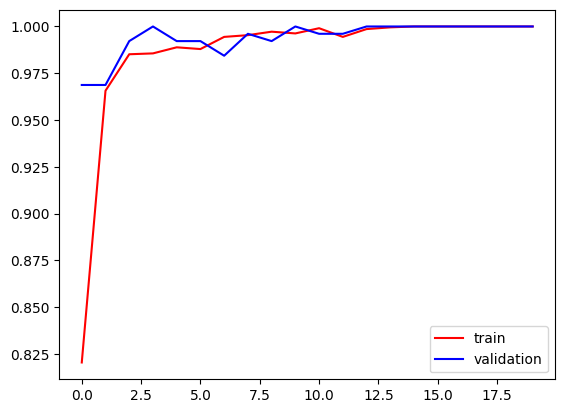

In [102]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

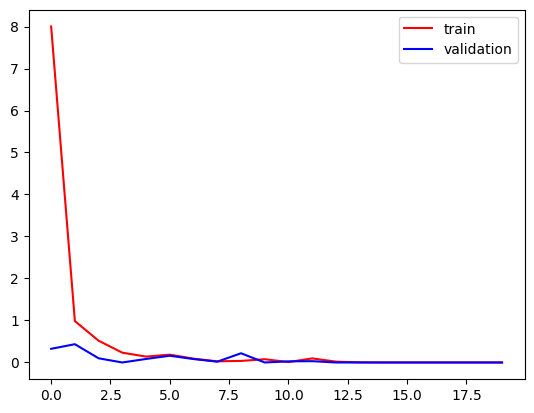

In [103]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

 Image to predict
Actual Label: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Label: Normal


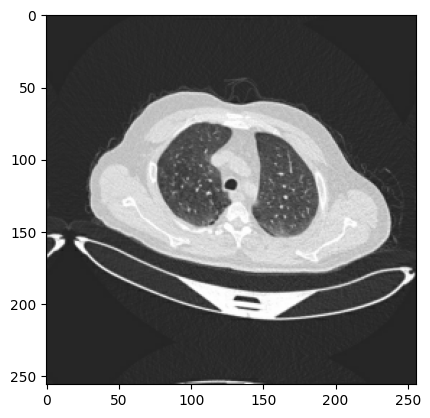

In [116]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print(" Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction=model_vgg_ft.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


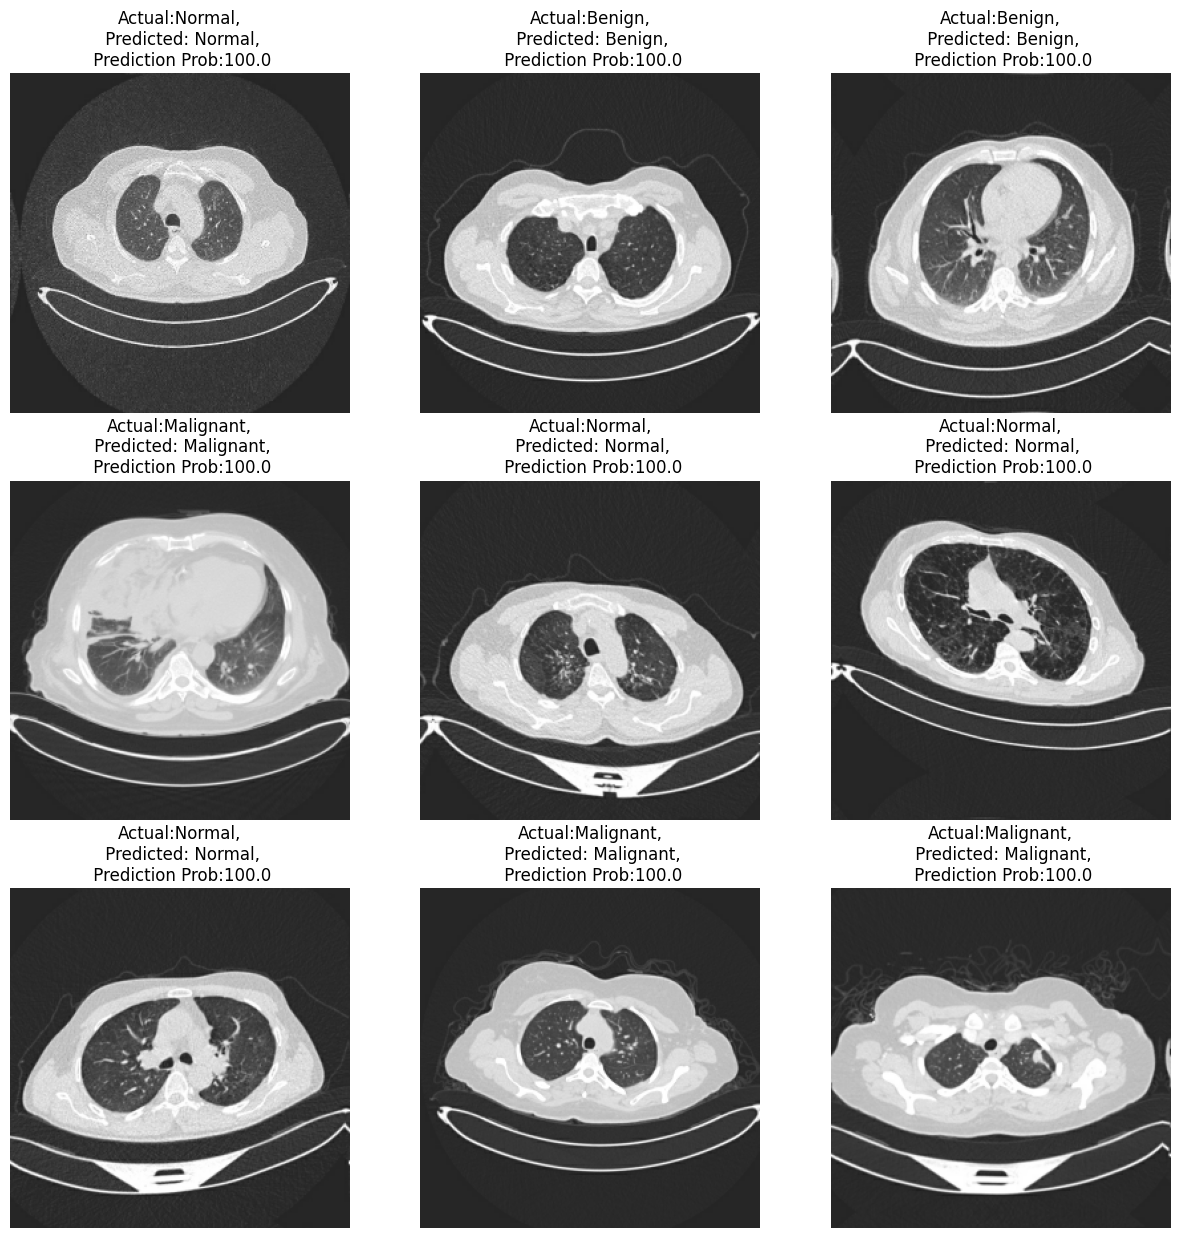

In [85]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model_vgg_ft,images[i].numpy())

        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Prediction Prob:{confidence}")
        plt.axis("off")

In [ ]:

model_vg.save('/content/drive/MyDrive/savedmodel/lung_cancer_vgg(without_ft).h5')

In [ ]:

model_vgg_ft.save('/content/drive/MyDrive/savedmodel/lung_cancer_vggnet(with_ft).h5')